<a href="https://colab.research.google.com/github/nicetak/notes-quant-macro/blob/main/python/life_cycle_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Life Cycle Model with CUDA
#### Kazuharu Yanagimoto

In [1]:
import datetime; datetime.datetime.now().strftime('%B %-d, %Y')

'January 7, 2022'

In [ ]:
!pip3 install QuantEcon

In [3]:
import math
import numpy as np
from numba import cuda, njit
from quantecon.markov.approximation import tauchen
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Model
This note examines the model of [Parallel Computing](https://github.com/davidzarruk/Parallel_Computing/).

For $t = 1, \dots, T$, households solve

$$\begin{aligned}
V(t, e, x) =& \max_{c, x'} \frac{c^{1 - \sigma}}{1 - \sigma} + \beta \mathbb{E}V(t + 1, e', x') \\
&\text{s.t. } \\
& c + x' \le (1 + r)x + ew \\
& \text{Pr}(e' | e) = \Gamma(e) \\
& x' \ge 0
\end{aligned}$$

In [4]:
# Grid for x
n_x = 1500
x_min = 0.1
x_max = 4.0
x_grid = np.linspace(x_min, x_max, num=n_x, dtype=np.float64)

# Grid for e
n_e = 15
ssigma_eps = 0.02058
lambda_eps = 0.99
m = 1.5
mc = tauchen(lambda_eps, ssigma_eps, 0.0, m, n_e)
e_grid, P = np.exp(mc.state_values), mc.P

# Utility function
ssigma = 2.0
bbeta = 0.97
T = 10

# Prices
r = 0.07
w = 5.0

In [5]:
@cuda.jit
def step(t, x_grid, e_grid, P, ssigma, bbeta, r, w, V):
    
    n_x = V.shape[0]
    n_e = V.shape[1]
    T = V.shape[2]

    ix, ie = cuda.grid(2)
    if ix < n_x and ie < n_e:

        utility = -np.inf
        for ixp in range(n_x):

            expected = np.float64(0)
            if t < (T-1):
                for iep in range(n_e):
                    expected += P[ie, iep] * V[ixp, iep, t+1]

            c = (1 + r) * x_grid[ix] + e_grid[ie] * w - x_grid[ixp]

            if c > 0:
                utility = max((c ** (1 - ssigma)) / (1 - ssigma) + bbeta * expected, utility)

        V[ix, ie, t] = utility

def solve_cuda(n_x, x_grid, n_e, e_grid, P, ssigma, bbeta, T, r, w):
    
    V = np.zeros((n_x, n_e, T), dtype = np.float64)
    for t in range(T-1, -1, -1):
        step[blocks_per_grid, threads_per_block](t, x_grid, e_grid, P, ssigma, bbeta, r, w, V)

    return V

In [6]:
@njit
def solve_cpu(n_x, x_grid, n_e, e_grid, P, ssigma, bbeta, T, r, w):

    V = np.zeros((n_x, n_e, T), dtype=np.float64)

    for t in range(T-1, -1, -1):
        for ix in range(n_x):
            for ie in range(n_e):

                utility = -np.inf
                for ixp in range(n_x):

                    expected = np.float64(0)
                    if t < (T-1):
                        for iep in range(n_e):
                            expected += P[ie, iep] * V[ixp, iep, t+1]

                    c = (1 + r) * x_grid[ix] + e_grid[ie] * w - x_grid[ixp]

                    if c > 0:
                        utility = max((c ** (1 - ssigma)) / (1 - ssigma) + bbeta * expected, utility)

                V[ix, ie, t] = utility
    
    return V

## Test

In [7]:
threads_per_block = (16, 16)
block_x = math.ceil(n_x/ threads_per_block[0])
block_y = math.ceil(n_e/ threads_per_block[1])
blocks_per_grid= (block_x, block_y)

V_cuda = solve_cuda(n_x, x_grid, n_e, e_grid, P, ssigma, bbeta, T, r, w)

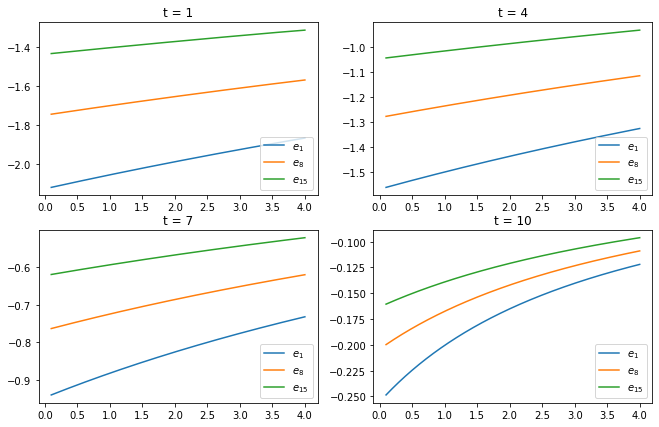

In [8]:
fig, axs = plt.subplots(2, 2, figsize = (11, 7))

for i in range(2):
  for j in range(2):
    t = [[0, 3], [6, 9]][i][j]
    axs[i, j].plot(x_grid, V_cuda[:, 0, t], label = r"$e_1$")
    axs[i, j].plot(x_grid, V_cuda[:, 7, t], label = r"$e_8$")
    axs[i, j].plot(x_grid, V_cuda[:, 14, t], label = r"$e_{15}$")
    axs[i, j].legend(loc = "lower right")
    axs[i, j].set_title(f"t = {t+1}")

plt.show()

In [9]:
V_cpu = solve_cpu(n_x, x_grid, n_e, e_grid, P, ssigma, bbeta, T, r, w)

In [10]:
np.all(np.isclose(V_cuda, V_cpu)) # Equivalence Check

True

## Benchmark

In [11]:
%timeit solve_cuda(n_x, x_grid, n_e, e_grid, P, ssigma, bbeta, T, r, w)

1 loop, best of 5: 509 ms per loop


In [12]:
%timeit V_cpu = solve_cpu(n_x, x_grid, n_e, e_grid, P, ssigma, bbeta, T, r, w)

1 loop, best of 5: 12 s per loop
